In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer


In [20]:
# Load dataset
customers = pd.read_csv("data/Customers.csv")
transactions = pd.read_csv("data/Transactions.csv")

In [4]:
# Feat. Engg

## Aggregate tx data
customer_spending = transactions.groupby("CustomerID").agg(
    total_spent=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    avg_order_value=('TotalValue', 'mean'),
    recency=('TransactionDate', lambda x: (pd.to_datetime('today') - pd.to_datetime(x)).min().days)
).reset_index()

In [21]:
data = customers.merge(customer_spending, on="CustomerID", how="left").fillna(0)
data.head()

,CustomerID,CustomerName,Region,SignupDate,total_spent,transaction_count,avg_order_value,recency
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5.0,670.904,84.0
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4.0,465.685,53.0
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4.0,681.345,154.0
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8.0,669.360,33.0
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3.0,678.080,82.0


In [76]:
# Get optimal no. of clusters

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[['total_spent', 'transaction_count', 'avg_order_value', 'recency']])

best_db_index = float('inf')
best_k = 2
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    db_index = davies_bouldin_score(X_scaled, labels)
    
    if db_index < best_db_index:
        best_db_index = db_index
        best_k = k
    
    print(f"{k = } \t db_index = {db_index}")

print(f"Best no. of clusters: {best_k}, db_index: {best_db_index}")

k = 2 	 db_index = 1.2471598139423274
k = 3 	 db_index = 1.0941070565276028
k = 4 	 db_index = 1.0067793634247582
k = 5 	 db_index = 1.0517829738908193
k = 6 	 db_index = 1.2198865222792412
k = 7 	 db_index = 1.1868581123280155
k = 8 	 db_index = 1.0458643004968784
k = 9 	 db_index = 1.1223081641973431
k = 10 	 db_index = 1.0563312630070472
Best no. of clusters: 4, db_index: 1.0067793634247582


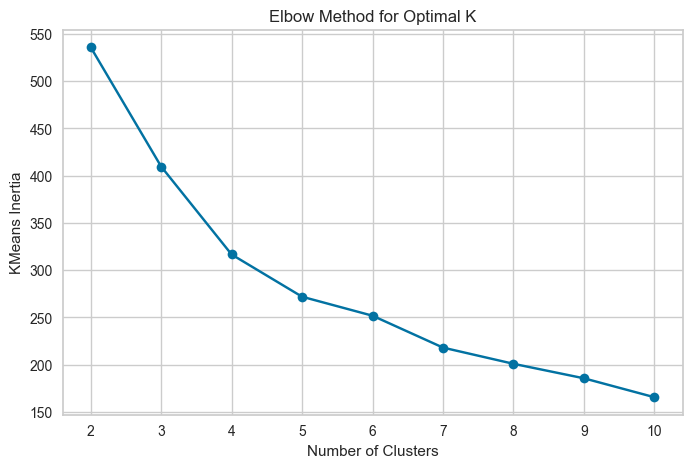

In [77]:
# Elbow Method for K selection (crosscheck)
km_inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    km_inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), km_inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("KMeans Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

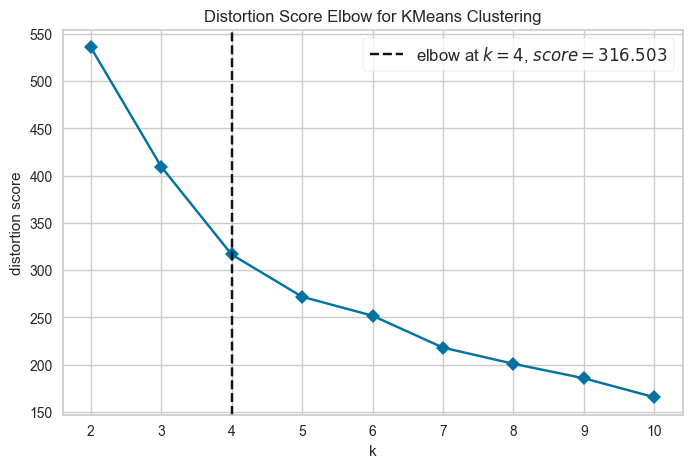

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [78]:
# Use KElbowVisualizer to Vis best K

model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 11), metric="distortion", timings=False)

plt.figure(figsize=(8, 5))
visualizer.fit(X_scaled)
visualizer.show()

In [79]:
# Train model
kmeans = KMeans(n_clusters=best_k, random_state=42)
data["Cluster"] = kmeans.fit_predict(X_scaled)


In [80]:
# Compute Metrics

## Silhouette Score
sil_avg = silhouette_score(X_scaled, data["Cluster"])
print(f"Silhouette Score = {sil_avg}")

## Calinski-Harabasz Index
ch_index = calinski_harabasz_score(X_scaled, data["Cluster"])
print(f"Calinski-Harabasz Index = {ch_index}")


Silhouette Score = 0.3158316459867128
Calinski-Harabasz Index = 99.80482673499537


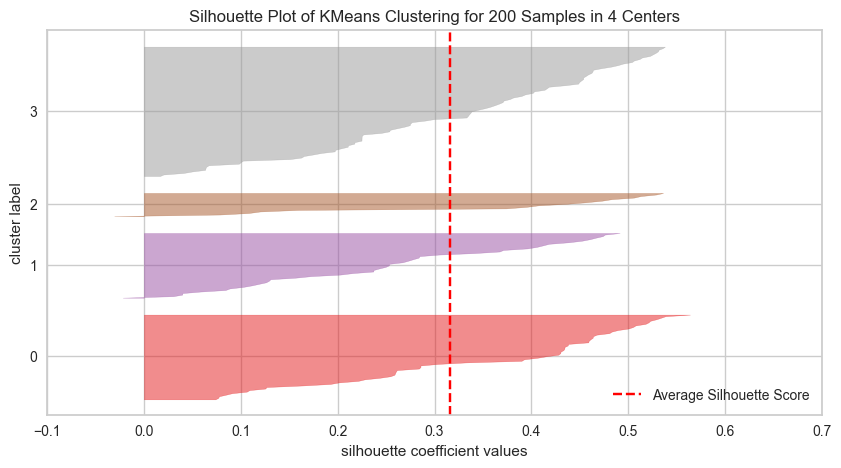

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 200 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [50]:
# Silhouette Plot
plt.figure(figsize=(10, 5))
vis = SilhouetteVisualizer(kmeans)
vis.fit(X_scaled)
vis.show()

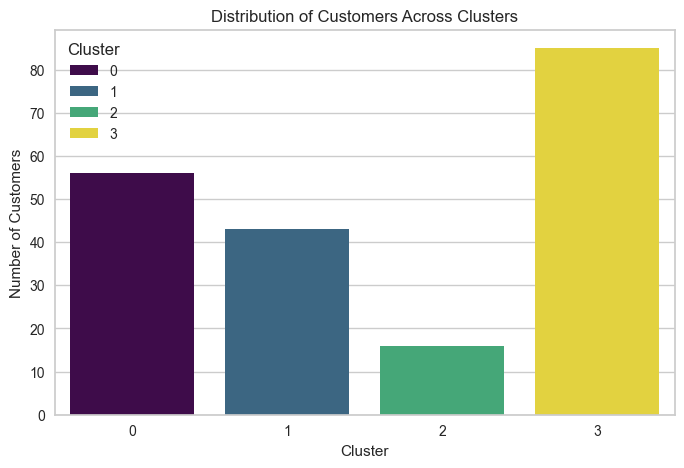

In [82]:
# Cluster Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x="Cluster", data=data, hue="Cluster", palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.title("Distribution of Customers Across Clusters")
plt.show()

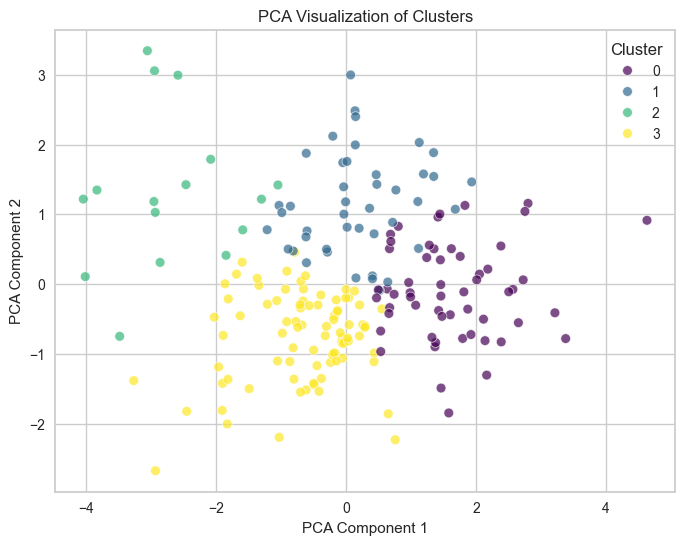

In [65]:
# PCA 2D Scatter Plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data["Cluster"], palette="viridis", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Clusters")
plt.legend(title="Cluster")
plt.show()

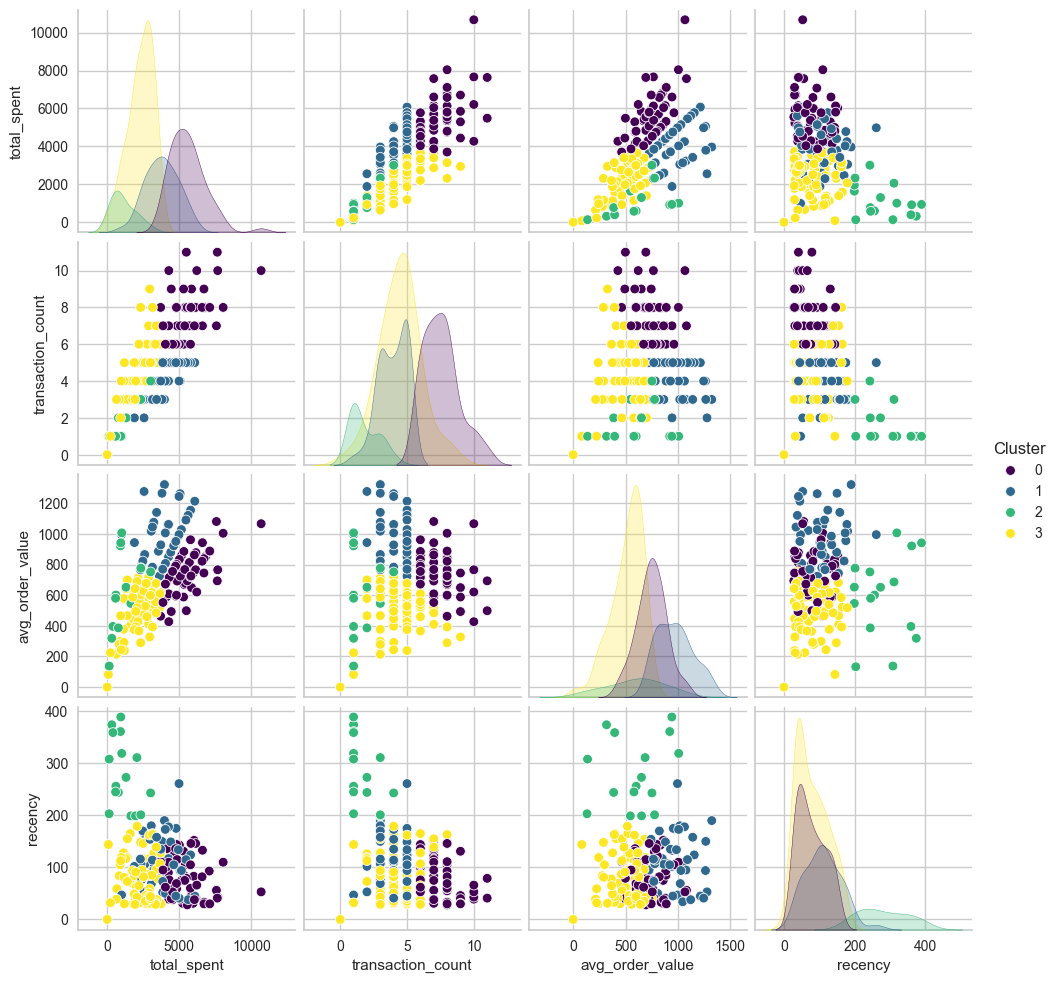

In [66]:
# Pair Plot of Features
sns.pairplot(data[['total_spent', 'transaction_count', 'avg_order_value', 'recency', 'Cluster']], 
             hue="Cluster", palette="viridis", diag_kind="kde")
plt.show()

        total_spent                                                         \
              count         mean          std      min       25%       50%   
Cluster                                                                      
0              56.0  5587.837857  1261.082634  3703.64  4722.360  5398.875   
1              43.0  3788.106512  1133.798691   995.52  3062.025  3850.220   
2              16.0  1132.325000   848.426060   132.64   534.340   932.365   
3              85.0  2306.716000   891.931299     0.00  1851.260  2488.010   

                             transaction_count            ... avg_order_value  \
               75%       max             count      mean  ...             75%   
Cluster                                                   ...                   
0        6136.7150  10673.87              56.0  7.553571  ...      842.710312   
1        4685.5200   6072.92              43.0  3.930233  ...     1069.796667   
2        1719.5325   3009.29              16.0  

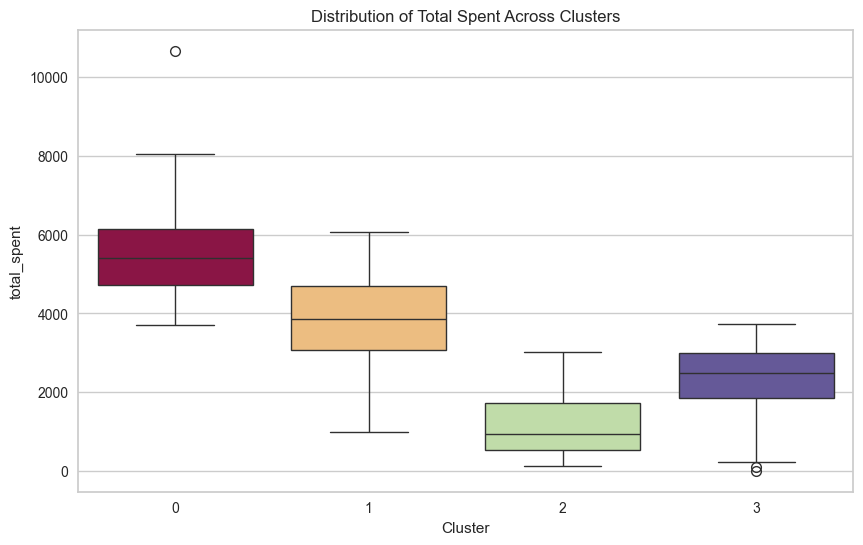

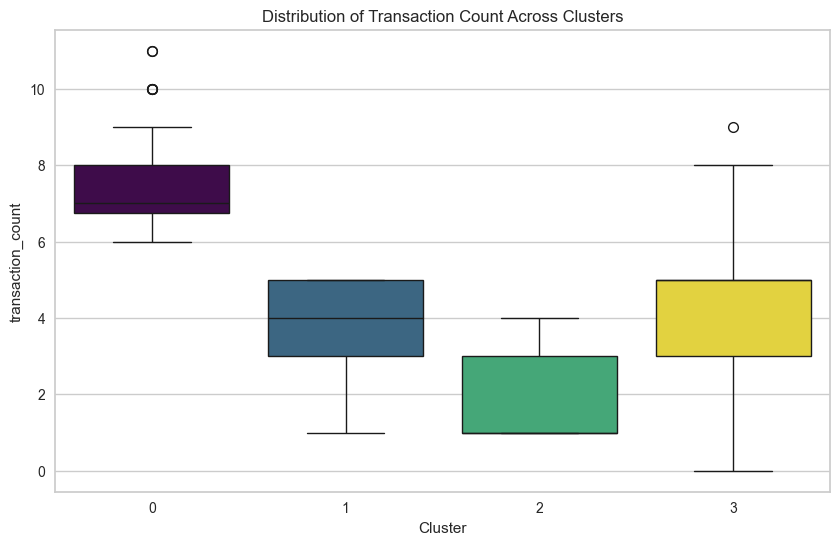

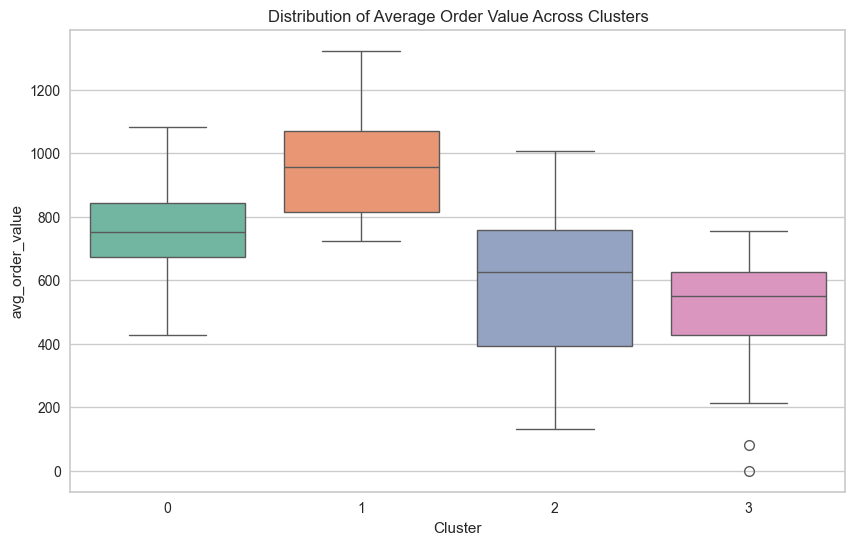

In [103]:
# Descriptive statistics for each cluster
cluster_summary = data.groupby('Cluster').describe()
print(cluster_summary)

# Vis. the distribution of features across clusters

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='total_spent', data=data, palette='Spectral', hue='Cluster', legend=False)
plt.title('Distribution of Total Spent Across Clusters')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='transaction_count', data=data, palette='viridis', hue='Cluster', legend=False)
plt.title('Distribution of Transaction Count Across Clusters')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='avg_order_value', data=data, palette='Set2', hue='Cluster', legend=False)
plt.title('Distribution of Average Order Value Across Clusters')
plt.show()
